# K-means univariated

## Proteinas, Calorias y Grasas

In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import joblib

In [2]:
ruta_csv = "../datasets/foundation-food.csv"
df = pd.read_csv(ruta_csv, sep=',')

In [3]:
df.head()

,id,water,calories,protein,total_fat,sfa,mufa,pufa,cholesterol,carbs,...,folic_acid,folate,food_based_folate,vitamin_b12,vitamin_a,retinol,vitamin_e,vitamin_d,vitamin_k,nutrient_count
0,344604,NaN,24.0,0.81,0.41,NaN,NaN,0.0,0.0,4.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
1,344605,NaN,24.0,0.81,0.41,NaN,NaN,0.0,0.0,4.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
2,344606,NaN,NaN,23.21,2.68,NaN,NaN,NaN,58.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
3,344607,NaN,NaN,23.21,2.68,NaN,NaN,NaN,58.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
4,344608,NaN,NaN,18.75,15.18,NaN,NaN,NaN,89.0,0.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9


# Analisis de calidad de datos

Nulos en 'calories': 23867
Nulos en 'protein': 5742
Nulos en 'total_fat': 27511
Nulos en 'carbs': 12459
Nulos en 'sodium': 19567
Nulos en 'potassium': 906956
Gráfico guardado en: ./out-resources/data_analysis/categories_nulls.png


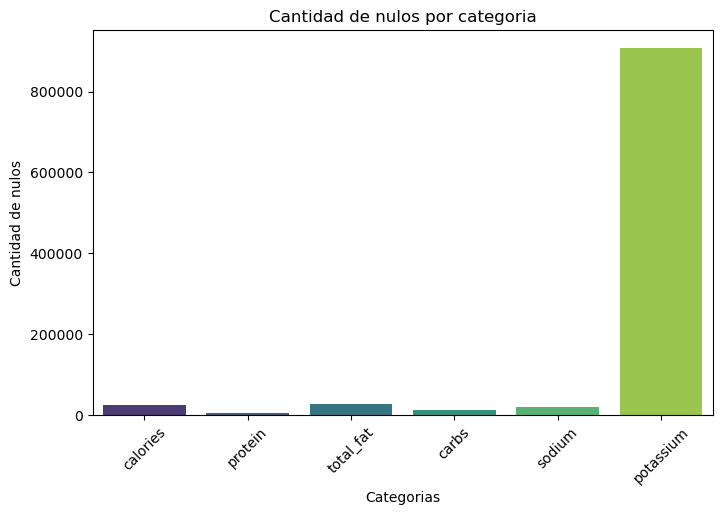

In [4]:
an_cols = ['calories', 'protein', 'total_fat', 'carbs', 'sodium', 'potassium']
an = df[an_cols]

# Contar nulos en cada columna seleccionada
null_counts = an[an_cols].isnull().sum()

# Imprimir los valores
for col, count in null_counts.items():
    print(f"Nulos en '{col}': {count}")

# Graficar
plt.figure(figsize=(8, 5))
sns.barplot(x=null_counts.index, y=null_counts.values, hue=null_counts.index, palette="viridis", legend=False)

# Personalizar etiquetas
plt.xlabel("Categorias")
plt.ylabel("Cantidad de nulos")
plt.title("Cantidad de nulos por categoria")
plt.xticks(rotation=45)

# Guardar imagen
filename = f"./out-resources/data_analysis/categories_nulls.png"
filepath = os.path.join(filename)
plt.savefig(filename, bbox_inches='tight')
print(f"Gráfico guardado en: {filename}")

# Mostrar gráfico
plt.show()

In [5]:
selected_cols = ['calories', 'protein', 'total_fat', 'carbs', 'sodium', 'potassium']

In [6]:
foods = df[selected_cols].copy()
foods = foods.sample(n=10000, random_state=42)

In [7]:
foods.head()

,calories,protein,total_fat,carbs,sodium,potassium
1055456,571.0,64.29,35.71,0.00,1929.0,NaN
1050427,350.0,12.00,0.00,74.00,2.0,NaN
382750,0.0,0.00,NaN,NaN,26667.0,NaN
309780,85.0,18.31,0.70,0.00,88.0,415.0
1246220,150.0,6.67,7.50,14.17,442.0,167.0


# Limpieza de datos

In [8]:
nulos_calories = foods['calories'].isnull().sum()
nulos_protein = foods['protein'].isnull().sum()
nulos_fats = foods['total_fat'].isnull().sum()
nulos_carbs = foods['carbs'].isnull().sum()

print(f"Nulos en 'calories': {nulos_calories}")
print(f"Nulos en 'protein': {nulos_protein}")
print(f"Nulos en 'total_fat': {nulos_fats}")
print(f"Nulos en 'carbs': {nulos_carbs}")

Nulos en 'calories': 161
Nulos en 'protein': 34
Nulos en 'total_fat': 173
Nulos en 'carbs': 82


In [9]:
foods = foods.dropna(subset=selected_cols)

# Verificar el número de registros eliminados
print(f"Registros eliminados: {len(df) - len(foods)}")

Registros eliminados: 1445325


In [10]:
def show_boxplots(data, cols, prefix="", output_dir="./out-resources/boxplots"):
    for col in cols:
        # Imprimir la distribución estadística
        print(f"Distribución de '{col}':")
        print(data[col].describe())
        print("-" * 40)

        # Crear el gráfico
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=data[col])
        # plt.title(f'Boxplot de {col}')
        plt.xlabel(col)
        plt.tight_layout()

        # Guardar imagen
        filename = f"{prefix}_boxplot_{col}.png" if prefix else f"boxplot_{col}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        print(f"Gráfico guardado en: {filepath}")
        
        plt.show()

In [11]:
def remove_outliers(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    mask = data[col].between(Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    return data[mask]

In [12]:
def clean_df_with_counts(data, cols):
    clean = data.copy()
    total_removed = 0

    for c in cols:
        before = len(clean)
        clean = remove_outliers(clean, c)
        removed = before - len(clean)
        total_removed += removed
        print(f"Outliers eliminados en '{c}': {removed}")

    print(f"Total de eliminaciones (sumando columnas): {total_removed}")
    return clean

In [13]:
def cluster_variable(df, column, n_clusters=3):
    values = df[[column]].values
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(values)

    print(f"Inercia para {column} con {n_clusters} clusters: {kmeans.inertia_:.2f}")
    
    df_clustered = pd.DataFrame({
        column: df[column].values,
        "cluster": kmeans.labels_
    })
    
    return df_clustered, kmeans

In [14]:
def print_cluster_summary(df_clustered, column):
    min_max_summary = df_clustered.groupby("cluster")[column].agg(["min", "max"])
    print(f"\nResumen de '{column}' por cluster:")
    print(min_max_summary)

    counts = df_clustered["cluster"].value_counts().sort_index()
    print("\nConteo de registros por cluster:")
    print(counts)

In [15]:
def plot_cluster_points(df_clustered, column):
    df_sorted = df_clustered.sort_values(by=column).reset_index(drop=True)

    plt.figure(figsize=(10, 4))
    for cluster in sorted(df_sorted["cluster"].unique()):
        sub = df_sorted[df_sorted["cluster"] == cluster]
        plt.scatter(sub.index, sub[column], label=f"Cluster {cluster}", s=60)

    # plt.title(f"Clustering univariado para '{column}'", fontsize=16)
    plt.xlabel("Índice ordenado", fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.legend()
    plt.tight_layout()

    # Guardar la imagen
    filename = f"./out-resources/clustering/{column}.png"
    plt.savefig(filename)
    print(f"Gráfico guardado como '{filename}'")
    
    plt.show()


In [16]:
def plot_elbow_method(df, column, k_max=10):
    values = df[[column]].values
    inercias = []

    for k in range(1, k_max + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(values)
        inercias.append(kmeans.inertia_)

    plt.figure(figsize=(6, 4))
    plt.plot(range(1, k_max + 1), inercias, marker="o", color="red", lw=2)
    # plt.title(f"Elbow Method para '{column}'")
    plt.xlabel("Número de Clusters (k)")
    plt.ylabel("Inercia")
    plt.grid(True)
    plt.tight_layout()

    # Guardar la imagen como 'elbow_columnname.png'
    filename = f"./out-resources/elbow_method/{column}.png"
    plt.savefig(filename)
    print(f"Gráfico guardado como '{filename}'")
    
    plt.show()

In [17]:
def export_model(col, model):
    path = f"./models/{col}-kmeans-model.pkl"
    joblib.dump(model, path)
    print(f"✅ Modelo de {col} guardado en {path}")

## Outliners

Distribución de 'calories':
count     3614.000000
mean       280.645268
std        654.208753
min          0.000000
25%         82.250000
50%        270.000000
75%        400.000000
max      37600.000000
Name: calories, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-cleaning_boxplot_calories.png


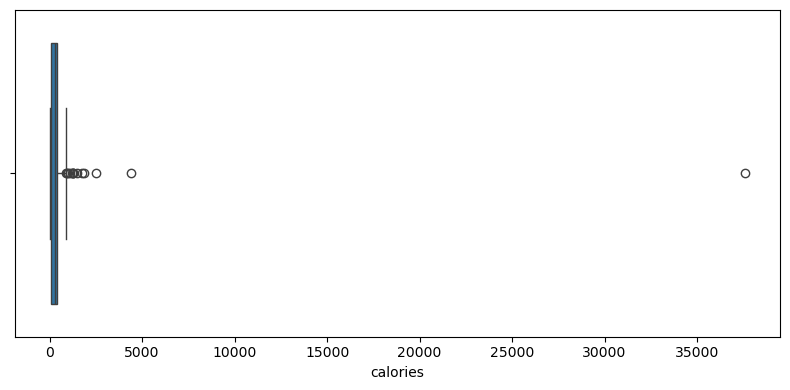

Distribución de 'protein':
count    3614.000000
mean        8.426021
std        16.993756
min         0.000000
25%         1.670000
50%         5.025000
75%        10.615000
max       760.000000
Name: protein, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-cleaning_boxplot_protein.png


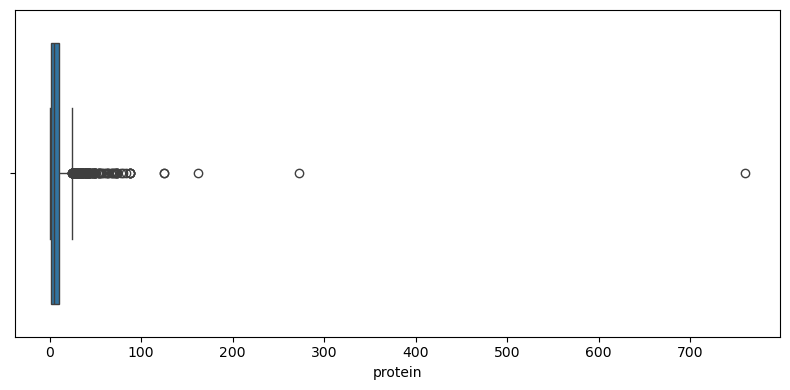

Distribución de 'total_fat':
count    3614.000000
mean       11.789665
std        24.340607
min         0.000000
25%         0.000000
50%         5.130000
75%        17.860000
max      1170.000000
Name: total_fat, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-cleaning_boxplot_total_fat.png


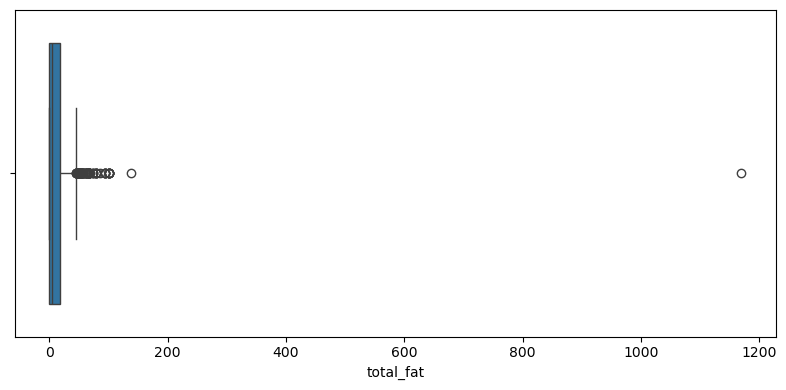

Distribución de 'carbs':
count    3614.000000
mean       36.391364
std       106.590480
min         0.000000
25%         8.330000
50%        26.320000
75%        60.000000
max      6160.000000
Name: carbs, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-cleaning_boxplot_carbs.png


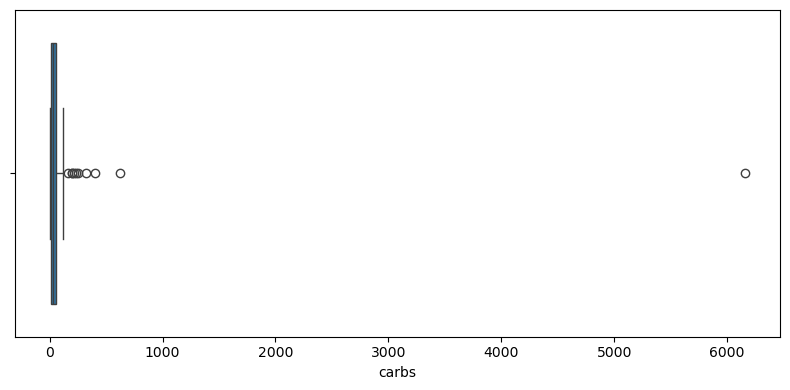

Distribución de 'sodium':
count      3614.000000
mean        496.445213
std        3718.238705
min           0.000000
25%          43.000000
50%         243.000000
75%         514.000000
max      156716.000000
Name: sodium, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-cleaning_boxplot_sodium.png


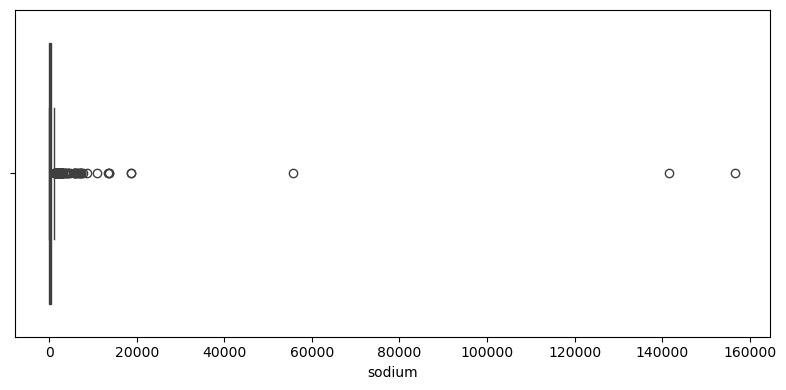

Distribución de 'potassium':
count      3614.000000
mean        937.664638
std       19939.700531
min           0.000000
25%          80.250000
50%         172.000000
75%         300.750000
max      925000.000000
Name: potassium, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-cleaning_boxplot_potassium.png


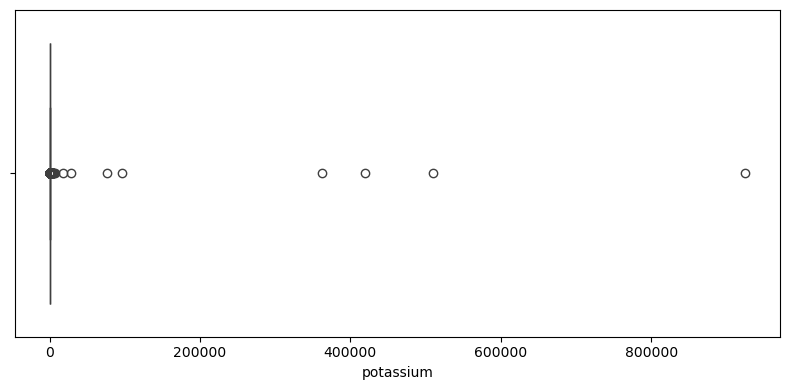

In [18]:
show_boxplots(foods, selected_cols, "pre-cleaning")

In [19]:
foods_clean = clean_df_with_counts(foods, selected_cols)

Outliers eliminados en 'calories': 14
Outliers eliminados en 'protein': 220
Outliers eliminados en 'total_fat': 146
Outliers eliminados en 'carbs': 2
Outliers eliminados en 'sodium': 120
Outliers eliminados en 'potassium': 241
Total de eliminaciones (sumando columnas): 743


## Outliners depurado

Distribución de 'calories':
count    2871.000000
mean      226.467085
std       164.940653
min         0.000000
25%        64.000000
50%       210.000000
75%       375.000000
max       600.000000
Name: calories, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-cleaning_boxplot_calories.png


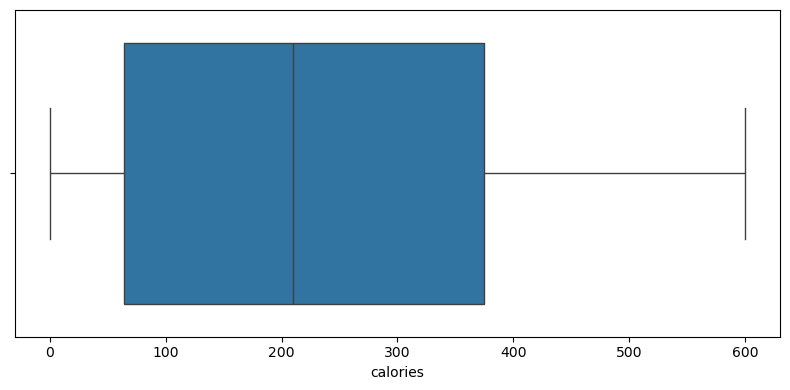

Distribución de 'protein':
count    2871.000000
mean        5.617409
std         5.276599
min         0.000000
25%         1.430000
50%         3.900000
75%         8.330000
max        23.810000
Name: protein, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-cleaning_boxplot_protein.png


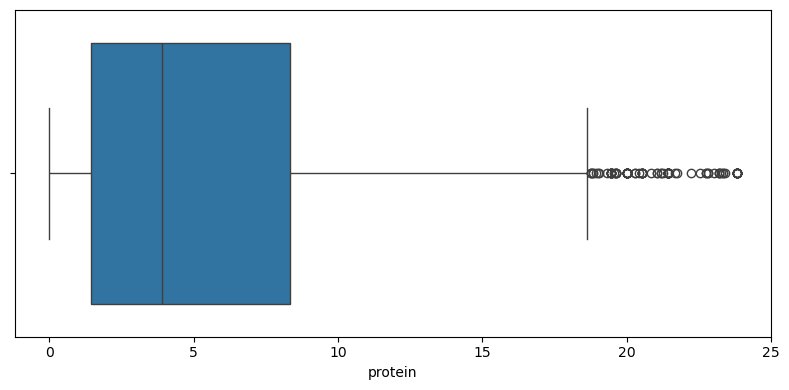

Distribución de 'total_fat':
count    2871.000000
mean        8.065632
std         9.655151
min         0.000000
25%         0.000000
50%         3.600000
75%        13.430000
max        41.180000
Name: total_fat, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-cleaning_boxplot_total_fat.png


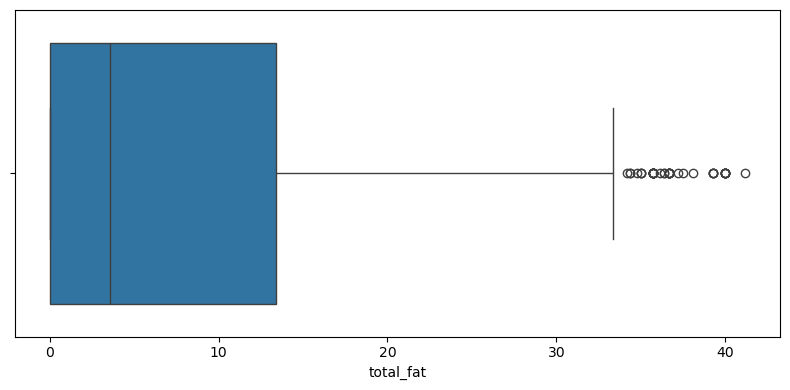

Distribución de 'carbs':
count    2871.000000
mean       33.583191
std        28.139278
min         0.000000
25%         8.000000
50%        23.960000
75%        60.000000
max       100.000000
Name: carbs, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-cleaning_boxplot_carbs.png


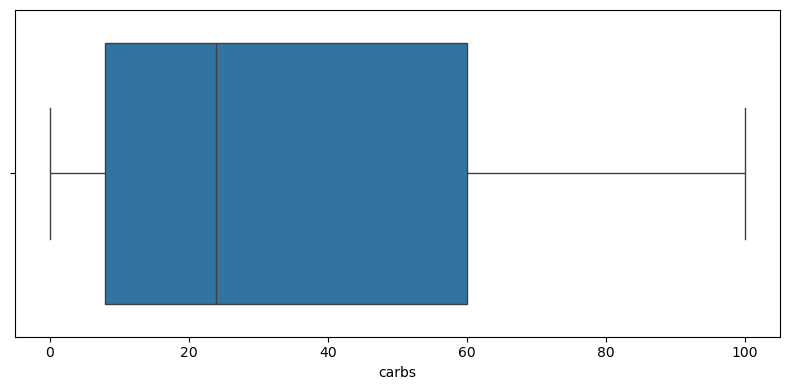

Distribución de 'sodium':
count    2871.000000
mean      268.109370
std       266.645985
min         0.000000
25%        38.500000
50%       200.000000
75%       427.500000
max      1143.000000
Name: sodium, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-cleaning_boxplot_sodium.png


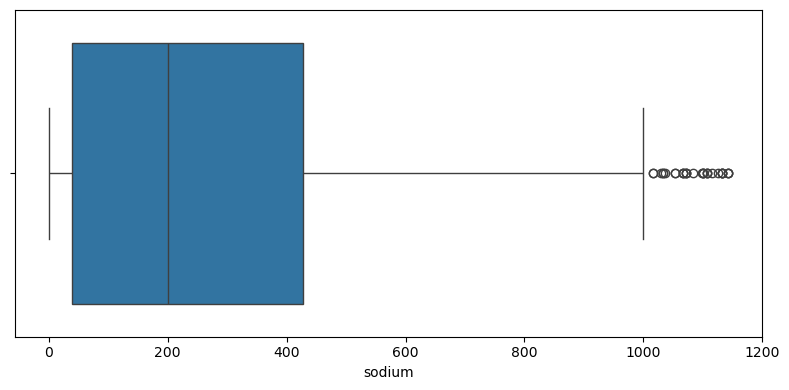

Distribución de 'potassium':
count    2871.000000
mean      163.081853
std       121.341810
min         0.000000
25%        71.000000
50%       150.000000
75%       232.500000
max       536.000000
Name: potassium, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-cleaning_boxplot_potassium.png


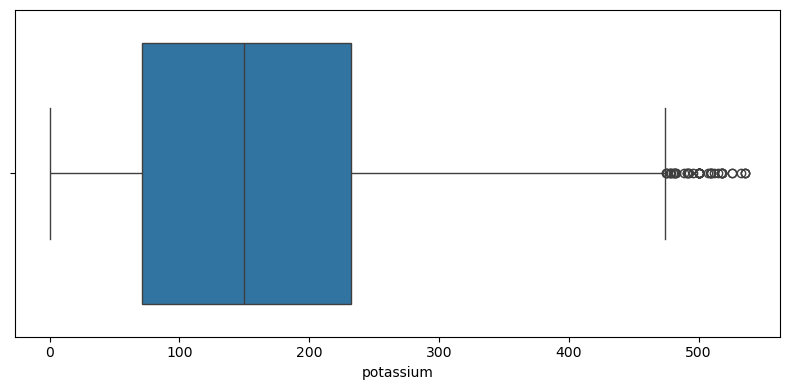

In [20]:
show_boxplots(foods_clean, selected_cols, "post-cleaning")

Inercia para calories con 3 clusters: 6844990.42
✅ Modelo de calories guardado en ./models/calories-kmeans-model.pkl

Resumen de 'calories' por cluster:
           min    max
cluster              
0        156.0  337.0
1          0.0  155.0
2        338.0  600.0

Conteo de registros por cluster:
cluster
0     674
1    1251
2     946
Name: count, dtype: int64
Gráfico guardado como './out-resources/clustering/calories.png'


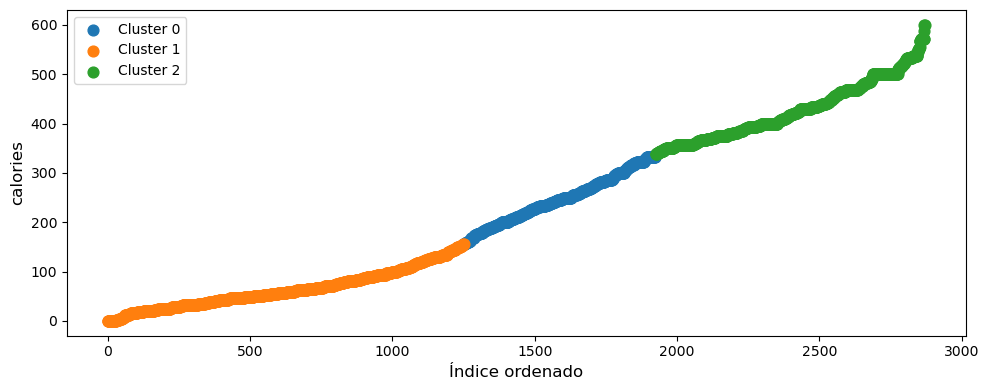

Gráfico guardado como './out-resources/elbow_method/calories.png'


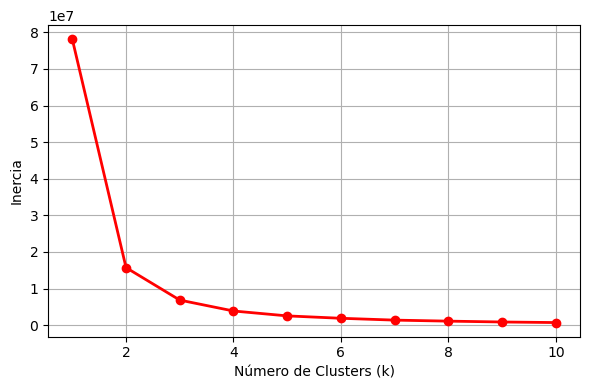

Inercia para protein con 3 clusters: 11696.67
✅ Modelo de protein guardado en ./models/protein-kmeans-model.pkl

Resumen de 'protein' por cluster:
           min    max
cluster              
0         5.32  12.96
1         0.00   5.31
2        13.00  23.81

Conteo de registros por cluster:
cluster
0     911
1    1678
2     282
Name: count, dtype: int64
Gráfico guardado como './out-resources/clustering/protein.png'


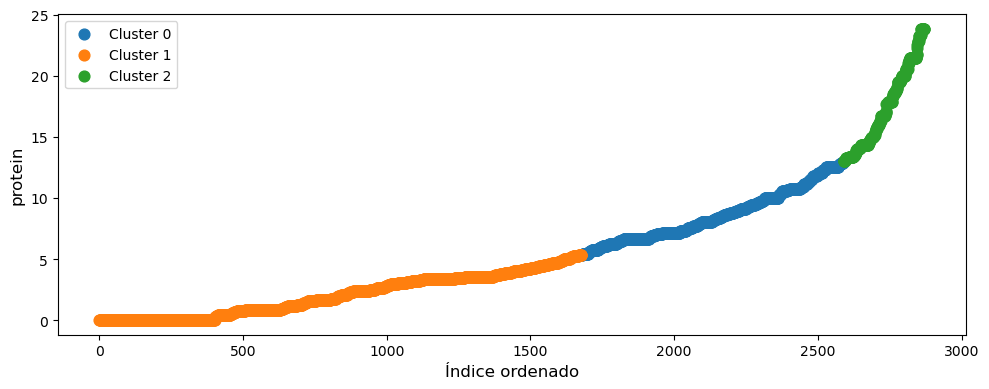

Gráfico guardado como './out-resources/elbow_method/protein.png'


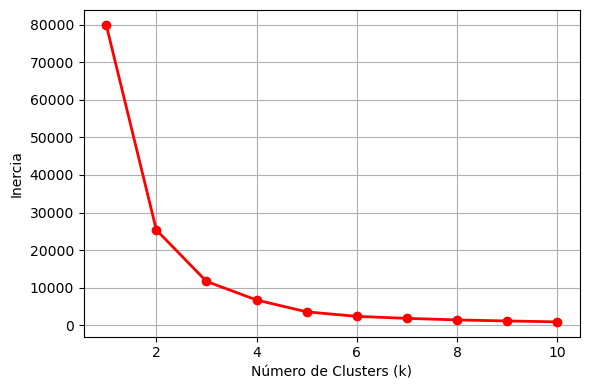

Inercia para total_fat con 3 clusters: 27233.33
✅ Modelo de total_fat guardado en ./models/total_fat-kmeans-model.pkl

Resumen de 'total_fat' por cluster:
           min    max
cluster              
0         6.94  19.35
1        19.44  41.18
2         0.00   6.90

Conteo de registros por cluster:
cluster
0     691
1     453
2    1727
Name: count, dtype: int64
Gráfico guardado como './out-resources/clustering/total_fat.png'


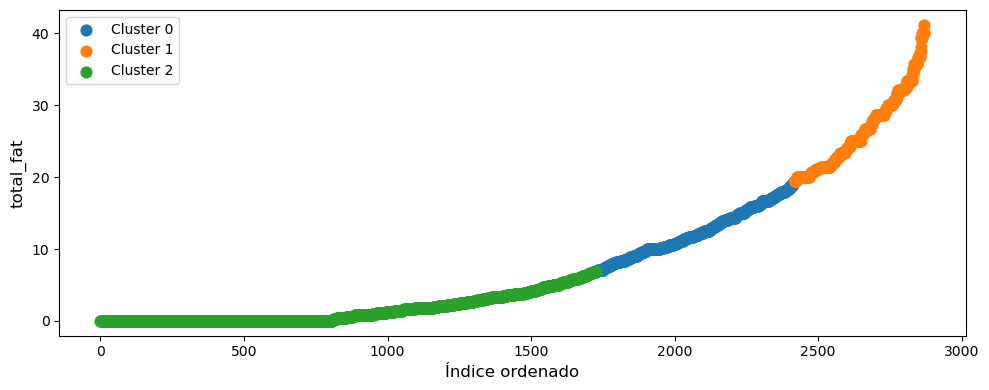

Gráfico guardado como './out-resources/elbow_method/total_fat.png'


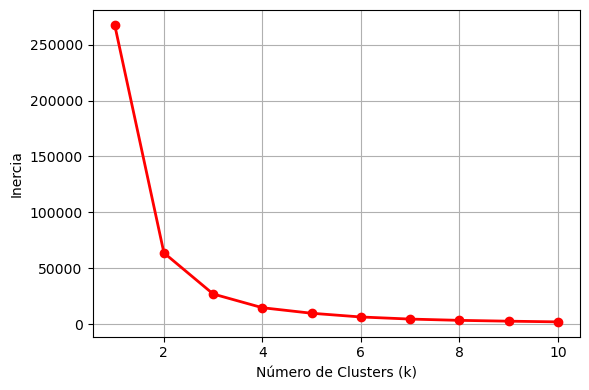

Inercia para carbs con 3 clusters: 196433.41
✅ Modelo de carbs guardado en ./models/carbs-kmeans-model.pkl

Resumen de 'carbs' por cluster:
          min     max
cluster              
0        56.0  100.00
1         0.0   24.58
2        24.7   55.88

Conteo de registros por cluster:
cluster
0     814
1    1448
2     609
Name: count, dtype: int64
Gráfico guardado como './out-resources/clustering/carbs.png'


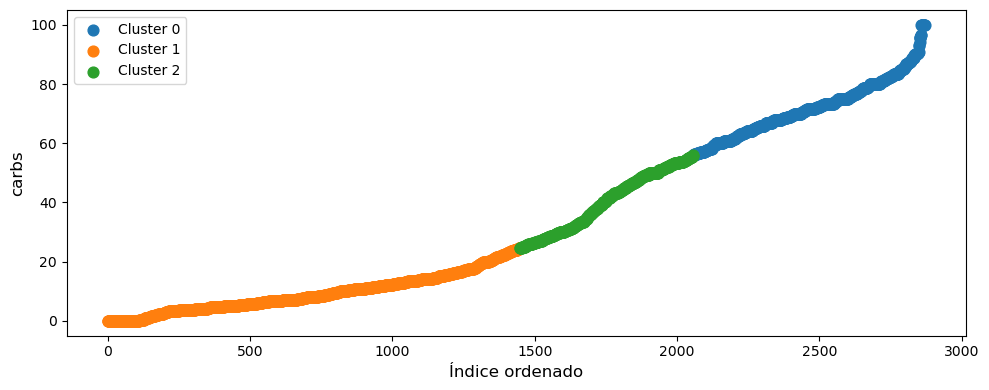

Gráfico guardado como './out-resources/elbow_method/carbs.png'


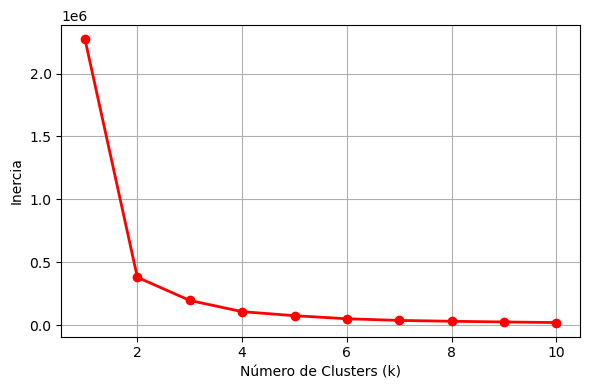

Inercia para sodium con 3 clusters: 23554089.05
✅ Modelo de sodium guardado en ./models/sodium-kmeans-model.pkl

Resumen de 'sodium' por cluster:
           min     max
cluster               
0          0.0   211.0
1        560.0  1143.0
2        212.0   557.0

Conteo de registros por cluster:
cluster
0    1471
1     450
2     950
Name: count, dtype: int64
Gráfico guardado como './out-resources/clustering/sodium.png'


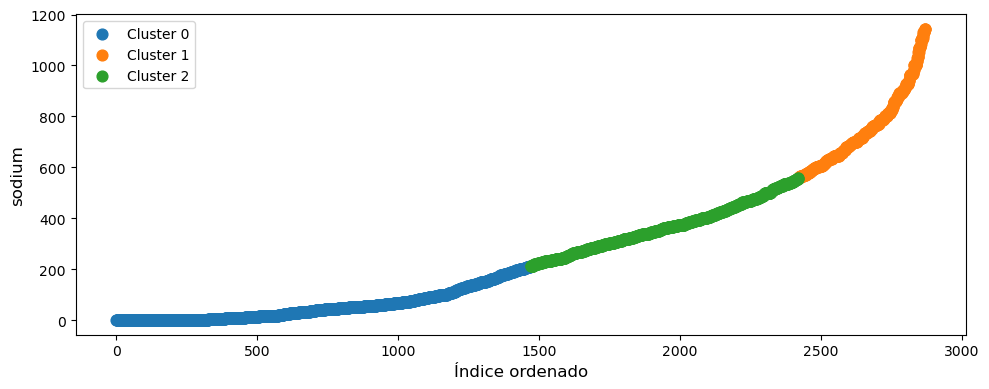

Gráfico guardado como './out-resources/elbow_method/sodium.png'


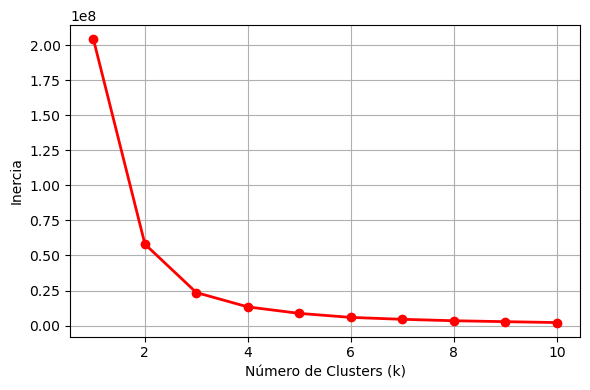

Inercia para potassium con 4 clusters: 3764618.23
✅ Modelo de potassium guardado en ./models/potassium-kmeans-model.pkl

Resumen de 'potassium' por cluster:
           min    max
cluster              
0          0.0   77.0
1        314.0  536.0
2         78.0  181.0
3        182.0  312.0

Conteo de registros por cluster:
cluster
0    769
1    357
2    952
3    793
Name: count, dtype: int64
Gráfico guardado como './out-resources/clustering/potassium.png'


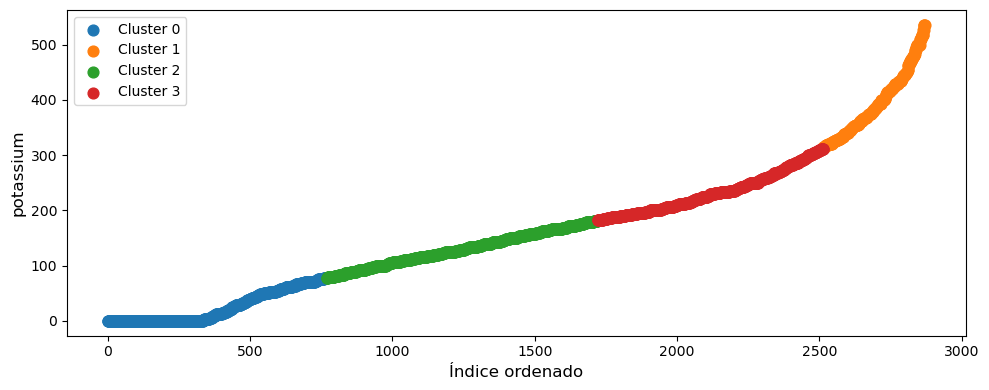

Gráfico guardado como './out-resources/elbow_method/potassium.png'


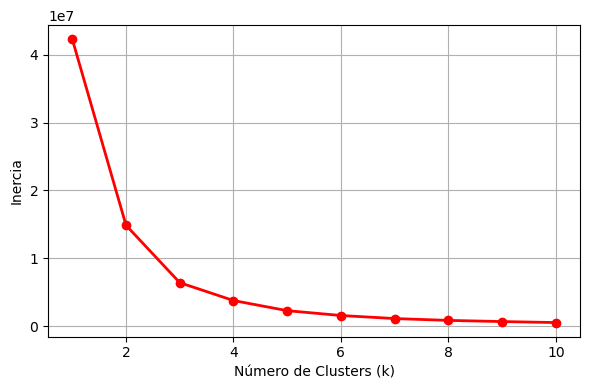

In [21]:
for col, k in zip(selected_cols, [3, 3, 3, 3, 3, 4]):
    clustered, kmeans = cluster_variable(foods_clean, col, n_clusters=k)
    export_model(col, kmeans)
    print_cluster_summary(clustered, col)
    plot_cluster_points(clustered, col)
    plot_elbow_method(foods_clean, col, k_max=10)